In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Mon Apr 14 19:48:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0              9W /   36W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import cv2
import os
from tqdm import tqdm
import itertools

In [5]:
# References: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_vision\pca_training"

CATEGORIES = ["clap", "jump", "nopeople", "punching", "pushpull", "rubhand", "squatting", "standing", "twist", "waving"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        break
    break

In [6]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

print(len(training_data))

100%|██████████| 1210/1210 [00:01<00:00, 894.23it/s]

12095


In [8]:
import random

random.shuffle(training_data)

In [9]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)  # Convert y to NumPy array

In [10]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [11]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [12]:
X = X/255.0
y = to_categorical(y, num_classes=10)

In [13]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [14]:
cnn.compile(  loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
history = cnn.fit(X, y, epochs=10, validation_split=0.25)
split_idx = int(0.75 * len(X))  # 75% training, 25% validation
X_val = X[split_idx:]
y_val = y[split_idx:]

val_loss, val_acc = cnn.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/10
284/284 [==============================] - 19s 13ms/step - loss: 2.0433 - accuracy: 0.2437 - val_loss: 1.7535 - val_accuracy: 0.3714
Epoch 2/10
284/284 [==============================] - 2s 9ms/step - loss: 1.6461 - accuracy: 0.3986 - val_loss: 1.6517 - val_accuracy: 0.3929
Epoch 3/10
284/284 [==============================] - 2s 8ms/step - loss: 1.4463 - accuracy: 0.4727 - val_loss: 1.4738 - val_accuracy: 0.4600
Epoch 4/10
284/284 [==============================] - 2s 9ms/step - loss: 1.3005 - accuracy: 0.5262 - val_loss: 1.4352 - val_accuracy: 0.4735
Epoch 5/10
284/284 [==============================] - 2s 8ms/step - loss: 1.1608 - accuracy: 0.5817 - val_loss: 1.4132 - val_accuracy: 0.4858
Epoch 6/10
284/284 [==============================] - 2s 8ms/step - loss: 1.0328 - accuracy: 0.6303 - val_loss: 1.4355 - val_accuracy: 0.4825
Epoch 7/10
284/284 [==============================] - 2s 8ms/step - loss: 0.9177 - accuracy: 0.6726 - val_loss: 1.5003 - val_accuracy: 0.4864
Epoc

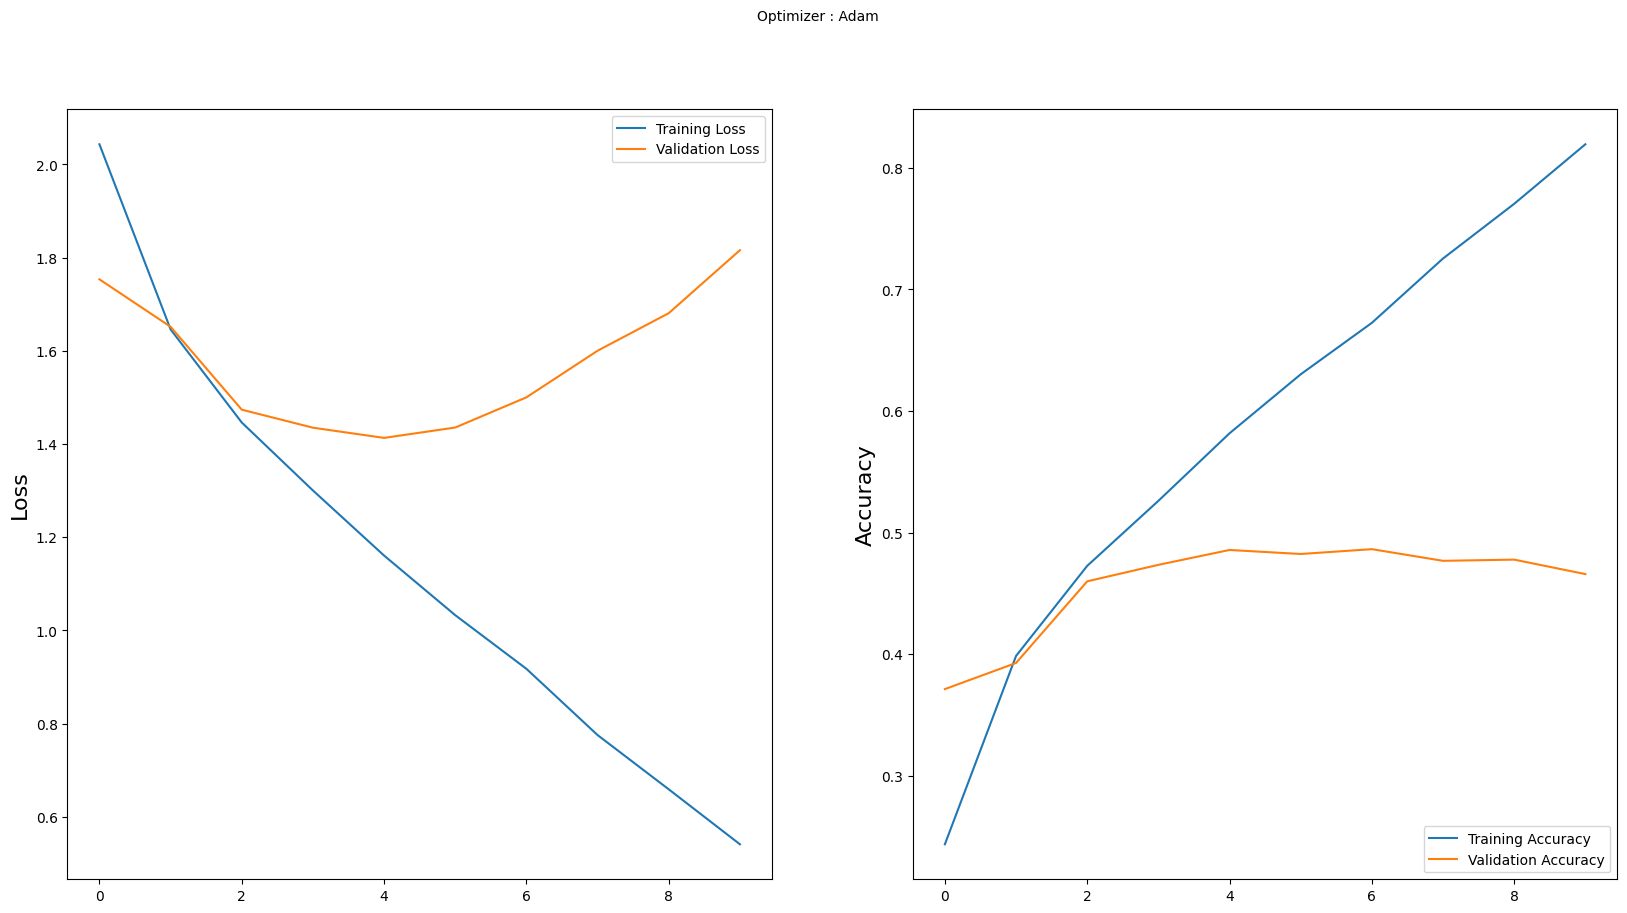

In [16]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

95/95 [==============================] - 0s 2ms/step


<Figure size 640x480 with 0 Axes>

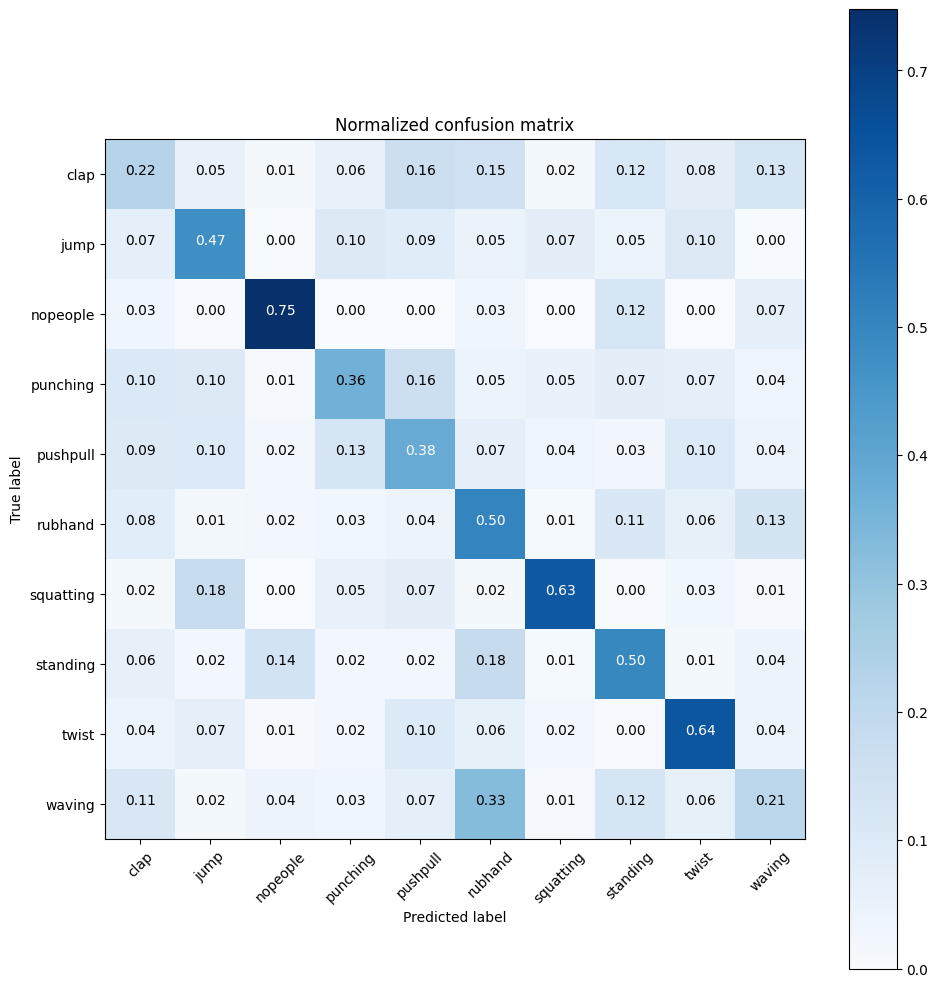

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

In [17]:
# Plot confusion matrix:
# Get predictions from the model on the validation set
y_pred_probs = cnn.predict(X_val)

y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_val, axis=1)

# Reference: https://github.com/parisafm/CSI-HAR-Dataset/blob/main/CNN.py
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=CATEGORIES, title='Normalized confusion matrix')
plt.show()

cnn.summary()